# Simple 1D Finite Plasticity model from "Continuum Mechanics of Solids"



In [1]:
import numpy as np

## Some parameters

In [2]:
N = 20 #Steps per quarter cycle
num_quart_cycles = 20 #Number of quarter cycles
strain_rate_sign = np.array([1, -1, -1,1])


e_dot = 0.001 # strain rate per second 
e_max = 0.01 # absolute value of maximum strain


E = 200e3 # Young’s modulus 
Y0 =100 # Initial yield 
h0 = 1250 # Initial hardening modulus 
Y_star = 250 # Yield saturation 
r = 1 #Hardening exponent 
C = 40e3#Backstress modulus 
gamma = 400 # Nonlinear kinematic parameter

T = e_max/e_dot # time per quarter cycle 
dt = T/N  # time step in each increment

e = np.zeros((N*num_quart_cycles+1,1))
ep = np.zeros((N*num_quart_cycles+1,1))
s = np.zeros((N*num_quart_cycles+1,1))
sigma = np.zeros((N*num_quart_cycles+1,1))
q = np.zeros((N*num_quart_cycles+1,1))
Y = np.zeros((N*num_quart_cycles+1,1))



In [3]:
n = 0
Y[0] = Y0

for i in range(num_quart_cycles):
    # Strain increment per time step 
    ii =np.mod(i,4) 
    de = strain_rate_sign[ii] * e_dot * dt
    
    for j in range(N):
        # New total strain at the end of this step 
        e[n+1] = e[n] + de
        
        # Trial stress 
        sigma_trial = sigma[n] + E * de
        xi_trial = sigma_trial - q[n]
        f_trial = np.abs(xi_trial) - Y[n]
        
        if(f_trial < 0): # Elastic step 
            sigma[n+1] = sigma_trial 
            Y[n+1] = Y[n] 
            ep[n+1] = ep[n]
            q[n+1] = q[n]
        else:
            #solve implicit equation for x=abs(dep)
            
            x = de/2
            dx = 100*x #large number
            
            while (np.abs(dx) > 1e-4 *np.abs(x)):
                eta = gamma*x/(1+gamma*x)
                g = abs(xi_trial + eta*q[n]) - (E + (1-eta) *C)*x - (Y[n] + h0*(1-Y[n]/Y_star)**r * x)
                deta_dx = gamma/(1+gamma*x) - gamma*gamma*x/((1+gamma*x)**2)
                dg = np.sign(xi_trial + eta*q[n]) * deta_dx*q[n] - (E + (1-eta)*C) + C*x*deta_dx  - h0*(1-Y[n]/Y_star)**r
                dx = -g/dg
                
                x = x + dx
                
            dep = x
            eta = gamma*x/(1+gamma*x)
            xi_bar_trial = xi_trial + eta*q[n]
            # Update ep(n+1), sigma(n+1), q(n+1)
            ep[n+1] = ep[n] + dep*np.sign(xi_bar_trial)
            sigma[n+1] = E*(e[n+1] - ep[n+1])
            Y[n+1] = Y[n] + h0*(1-Y[n]/Y_star)**r * dep
            q[n+1] = (1-eta) * (q[n] + C*dep*np.sign(xi_bar_trial))
        n=n+1
        

            
                
            
        
    

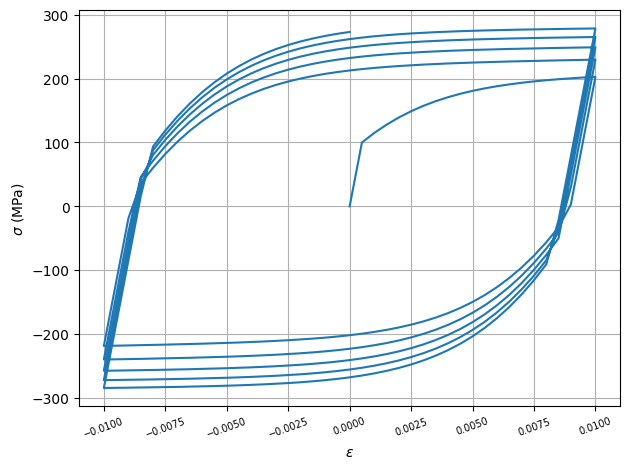

In [4]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(e,sigma)
plt.xlabel(r"$\epsilon$")
plt.xticks(rotation=20,fontsize=7)
plt.ylabel("$\sigma$ (MPa)")
plt.tight_layout()
plt.grid()

In [5]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt


plt.rcParams["animation.ffmpeg_path"] = "/usr/bin/ffmpeg"


def plot_animation(
    name, x, y, ylabel, xlabel
):
    fig = plt.figure()
    fig.set_size_inches(7, 5)

    def animate(i):
        plt.cla()

        plt.plot(x[0:i], y[0:i], '--',linewidth=1.5)
        plt.grid(linestyle="--", linewidth=0.5, color="b")
        
        axes = fig.get_axes()[0]
        axes.set_ylabel(ylabel)
        from matplotlib.ticker import AutoMinorLocator
        
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        axes.set_xlabel(xlabel)
        # ax2.plot(timeHist2[0:i], timeHist0[0:i], c=colors[0], linewidth=1.5)
        # ax2.grid(linestyle="--", linewidth=0.5, color="b")
        # ax2.set_xlabel("Time (s)")
        # ax2.set_ylabel(ylabel2)
        # from matplotlib.ticker import AutoMinorLocator

        # ax2.xaxis.set_minor_locator(AutoMinorLocator())
        # ax2.yaxis.set_minor_locator(AutoMinorLocator())

        axes.set_xlim(-.011, .011)
        axes.set_ylim(-260, 260)
        # ax2.set_ylim(-6.5, 6.6)

    set_fps = 24*3
    ani = FuncAnimation(
        fig, animate, interval=1000 / set_fps, save_count=len(x)
    )

    f = r"media/"+name+".mp4"
    writervideo = FFMpegWriter(fps=set_fps)
    ani.save(f, writer=writervideo)

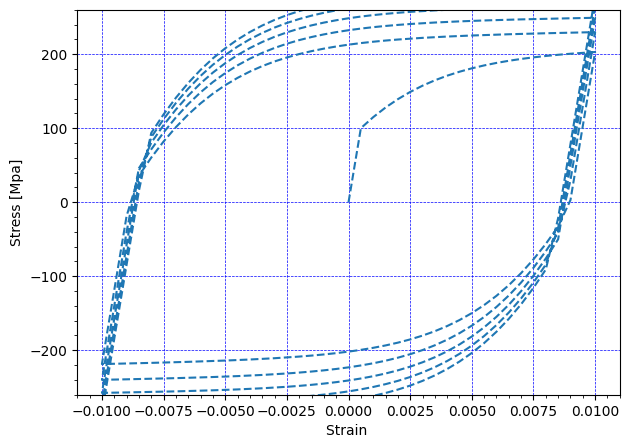

In [6]:
plot_animation("Test5",e, sigma,  r"Stress [Mpa]", r"Strain ")
